## Import Library and Funcitons

In [1]:
import datetime
import logging
import numpy as np
import pandas as pd
import sklearn.metrics
import xgboost
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from ds_utils import e4
from ds_utils import aggregators
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [5]:
def mxdiff(arr):
    return np.max(np.diff(arr))
    
def training_from_pir(pir: int, part: int = None, base_path: str = None) -> pd.DataFrame:
    """Get training data for a person in recovery given a known base path
    Args:
        pir (int): person in recovery id number
        part (int, optional): part of the file to load. Defaults to None.
    Returns:
        pd.DataFrame: aggregated data for a person in recovery
    
    """
    agg = {
    'acc_x': [aggregators.std, mxdiff],
    'acc_y': [aggregators.std, mxdiff],
    'acc_z': [aggregators.std, mxdiff],
    'heartrate': [aggregators.mean, aggregators.std, aggregators.agg_linear_trend],
    'conductance': [aggregators.mean, aggregators.std],
    'temperature': [aggregators.mean, aggregators.std],
    'bvp': [aggregators.mean, aggregators.std]
    }

    print('Loading file')
    start = datetime.datetime.now()

    data = e4.read(pir, part=part, base_path=base_path).add_craving_onset(1, 0, column_name='craving_onset')
    print(f'Loading time: {(datetime.datetime.now() - start).total_seconds()}')

    start = datetime.datetime.now()
    agg_data = data.aggregate(500, agg, ['1 min','1 h'], sample_column='craving_onset')
    print(f'Aggregation time: {(datetime.datetime.now() - start).total_seconds()}')
    
    return agg_data

def training_to_xgb(dfs) -> xgboost.XGBClassifier:
    """Pass a list of dataframes to be used as training data for an XGBoost classifier
    Args:
        dfs (list[pd.DataFrame]): a list of aggregated data dataframes
    Returns:
        xgboost.XGBClassifier: a trained classifier
    
    """
    data = pd.concat(dfs, axis=0)
    X = data.drop(columns=['craving_onset']).values
    Y = data['craving_onset'].map({True: 1, False: 0}).values

    model = xgboost.XGBClassifier(max_depth=9, subsample=0.9, colsample_bytree=0.3, objective='binary:logistic', n_estimators=400, learning_rate=0.15)
    model.fit(X, y)
    
    return model


def test_xgb(df: pd.DataFrame, model: xgboost.XGBClassifier) -> np.ndarray:
    """Make predictions from a trained xgboost model on aggregated data
    Args:
        df (pd.DataFrame): test dataframe
        model (xgboost.XGBClassifier): trained model
    Returns:
        np.ndarray: the predicted values
    
    """
    X = df.drop(columns=['craving_onset']).values
    Y = df['craving_onset'].map({True: 1, False: 0}).values

    Y_pred = model.predict(X)
    predictions = [round(value) for value in Y_pred]
    accuracy = sklearn.metrics.accuracy_score(Y, Y_pred)
    precision = precision_score(Y, Y_pred, average='macro')
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Precision: %.2f%%" % (precision * 100.0))
    print(sklearn.metrics.confusion_matrix(Y, Y_pred))
    return Y_pred

def prepare_data(pir, part, agg, time_windows):
    """Prepare data for predictions on the interested emotion.The returned dataframe will include all six emotions
        The function use aggregate function in ds_util
    Args:
        pir (int): person in recovery id number
        part (int): part of the file to load
        agg (Union[Dict[str, Callable], Iterable[Dict[str, Callable]]]): a dict of functions to apply to each column, 
                with keys as column names, or a list of dicts of functions separated for each window
        time_windows (Iterable[str]): a list of a window sizes in units that can be used for resample
    Returns: 
        pd.DataFrame: data with all six emotions ready for the xgboost model (and function XGBRegressorForSurveyFast)
    """
    emotion_list = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad']
    data = e4.read(pir, part=part, base_path='./data').add_craving_onset(1, 0, column_name='craving_onset')
    status = pd.read_parquet(f'./data/pir{pir}_status.pq', engine='auto')

    for emotion in emotion_list:
        status = status[status[emotion].first_valid_index():status[emotion].last_valid_index()]
    data = data.aggregate(500, agg, time_windows, sample_column='craving_onset')

    df = data.join(status, how='outer').sort_index()
    drop_list=['hash', 'is_craving', 'report_offset_hrs','id', 'duration_participation_s','craving_freq', 
               'need_help', 'support', 'report', 'cravings_today']
    df= df.drop(drop_list,axis=1)
    df = df[df['bvp'].first_valid_index():df['bvp'].last_valid_index()]

    for emotion in emotion_list:
        df = df[df[emotion].first_valid_index():df[emotion].last_valid_index()]

    for emotion in emotion_list:
        df[emotion] = df[emotion].ffill()

    df=df.dropna()
    
    return df

def XGBRegressorForSurveyFast (df, test, emotion, learning_rate = 0.15, max_depth = 9, colsample_bytree = 0.3,
                           subsample = 0.9):
    """predict the pir's emotions on a scale from 1 to 10  
    
    Args: 
        df (pd.DataFrame): the data set we need for the training and test data
        emotion (str): the emotion we are going to predict
        learning_rate (float): learning rate of XGB model, range [0, 1]. Defaults to 0.1
        max_depth (int): maximum depth of tree. Defaults to 5
        colsample_bytree (float): fraction of columns to be randomly sampled for each tree. Defaults to 0.3
        subsample (float): fraction of observations to be randomly sampled for each tree. Defaults to 0.8
    Return:
        xgboost.XGBRegressor: a trained regressor to predict on emotions
    """  
    
    # delete uneccessary columns
    emotionList = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad'] 
    emotionList.remove(emotion)
    dropList = emotionList + ['craving_onset']
    df = df.drop(dropList, axis=1)
    test = test.drop(dropList, axis=1)

     # get the name of columns for features
    new_cols = [col for col in df.columns if col != emotion] + [emotion]
    df = df[new_cols]
    test = test[new_cols]
    feature_columns = new_cols[:-1]

    # Isolate the x and y variables
    y = df.iloc[:, -1].values
    X = df.iloc[:, :-1].values
    
    test_y = test.iloc[:, -1].values
    test_X = test.iloc[:, :-1].values   
    
    finalModel = xgb.XGBRegressor(objective="reg:squarederror", learning_rate = learning_rate, max_depth = max_depth,
                                  colsample_bytree = colsample_bytree, subsample = subsample, n_estimators=100,random_state=123)
    finalModel.fit(X, y)
    
    # Predictions on test dataset
    preds = finalModel.predict(test_X)
    
    # plot pred and pred-actual
    fig, ax = plt.subplots(3, 1, figsize=(12,12))
    ax[0].hist(preds, bins = 50)
    ax[1].hist(test_y, bins = 50)
    ax[2].hist(preds - test_y, bins = 50)
    ax[0].set_title('pred')
    ax[1].set_title('actual')
    ax[2].set_title('pred - actual')

    plt.show()
    
    # show results
    rmse = np.sqrt(mean_squared_error(test_y, preds))
    print("RMSE: %f" % (rmse))
    
    
    # plot feature importances
    xgb.plot_importance(finalModel, max_num_features = 10)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    
    # plot true val vs. predictions
    true_val = test[emotion].values
    plt.plot(true_val)
    plt.plot(preds)
    plt.title("true val vs. predictions")
    plt.show()
    return finalModel

def df_with_emotion(df, model, emotion):
    """produce a new dataframe with predicted emotion attached to it
    
    Args: 
        df (pd.DataFrame): can be the same data used for the emotion prediction
        model (xgboost.XGBRegressor): used to produce prediction on the emotion
        emotion (str) : the emotion we are interested in
    Return:
        pd.DataFrame: a dataframe with the interested emotion attached
    """
    emotionList = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad']
    dropList = emotionList + ['craving_onset']
    df_X = df.drop(dropList, axis=1, errors='ignore')
    df[f"pred_{emotion}"] = model.predict(df_X.values)
    df = df.drop(emotionList, axis=1, errors='ignore')
    return df

def classify(train, test):
    X = train.drop(columns=['craving_onset']).values
    Y = train['craving_onset'].map({True: 1, False: 0}).values
    negs = np.arange(len(Y))[Y == 0]
    use_Y = (Y > 0)
    use_Y[np.random.choice(negs, int(1.5*sum(Y)))] = True
    X = X[use_Y, :]
    Y = Y[use_Y]
    model = xgboost.XGBClassifier(max_depth=9, subsample=0.9, colsample_bytree=0.3, objective='binary:logistic', n_estimators=100, learning_rate=0.15)
    model.fit(X, Y, eval_metric=["error", "logloss"])
    X_test = test.drop(columns=['craving_onset']).values
    Y_test = test['craving_onset'].map({True: 1, False: 0}).values
    y_pred = model.predict(X_test)
    best_preds = [round(value) for value in y_pred]
    precision = sklearn.metrics.precision_score(Y_test, best_preds, average='macro')
    accuracy = sklearn.metrics.accuracy_score(Y_test, best_preds)
    print(precision, accuracy)
    print(sklearn.metrics.confusion_matrix(Y_test, best_preds))
    return model

## Set parameters

In [6]:
df1 = training_from_pir(89, 1,"./data")

Loading file
Loading time: 77.286073
ts datetime64[ns]
1 min
ts datetime64[ns]
1 h
ts datetime64[ns]
Aggregation time: 67.95746


In [7]:
df2 = training_from_pir(89, 2,"./data")
df3 = training_from_pir(89, 3,"./data")
df4 = training_from_pir(89, 4,"./data")

Loading file
Loading time: 77.018195
ts datetime64[ns]
1 min
ts datetime64[ns]
1 h
ts datetime64[ns]
Aggregation time: 64.731335
Loading file
Loading time: 66.763351
ts datetime64[ns]
1 min
ts datetime64[ns]
1 h
ts datetime64[ns]
Aggregation time: 64.086397
Loading file
Loading time: 83.879569
ts datetime64[ns]
1 min
ts datetime64[ns]
1 h
ts datetime64[ns]
Aggregation time: 73.533339


In [26]:
tain_0 =  pd.concat([df1, df2, df3], axis=0)
model0 = classify(tain_0, df4)

0.5839964633068082 0.538
[[227  23]
 [208  42]]


In [ ]:
y = test_xgb(df4, model)

In [29]:
agg = {
    'acc_x': [aggregators.std, mxdiff],
    'acc_y': [aggregators.std, mxdiff],
    'acc_z': [aggregators.std, mxdiff],
    'heartrate': [aggregators.mean, aggregators.std, aggregators.agg_linear_trend],
    'conductance': [aggregators.mean, aggregators.std],
    'temperature': [aggregators.mean, aggregators.std],
    'bvp': [aggregators.mean, aggregators.std]
    }

time_windows = ['1 min', '1 h'] 

df1 = prepare_data(89, 1, agg, time_windows)
df1.head()

ts datetime64[ns]
1 min
ts datetime64[ns]
1 h
ts datetime64[ns]


,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,craving_onset,acc_x_1min__std,acc_x_1min__mxdiff,...,temperature_1h__mean,temperature_1h__std,bvp_1h__mean,bvp_1h__std,relaxed,happy,stressed,tired,anxious,sad
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-28 22:25:25.750000,-50.0,8.0,36.0,-207.130000,0.071755,84.83,30.05,False,9.045650,48.0,...,31.279694,0.702278,-0.102442,178.906788,6.0,6.0,7.0,7.0,7.0,5.0
2020-01-28 23:14:29.406250,-50.0,42.0,6.0,265.620000,0.047409,68.77,33.83,False,10.293232,65.0,...,32.570649,1.359237,-1.107961,206.501620,6.0,6.0,7.0,7.0,7.0,5.0
2020-01-29 01:03:03.781250,39.0,47.0,1.0,-153.636667,0.155041,78.07,33.39,False,24.924040,47.0,...,33.288559,0.690618,-2.269165,195.884236,6.0,6.0,7.0,7.0,7.0,5.0
2020-01-29 05:59:54.531250,-48.0,32.0,-29.0,-112.740000,0.116868,83.95,34.43,False,0.000000,0.0,...,34.406629,0.128263,0.515853,116.332746,6.0,6.0,7.0,7.0,7.0,5.0
2020-01-29 09:37:22.343750,-47.0,35.0,27.0,-131.860000,0.575585,78.13,33.47,False,0.746537,5.0,...,33.349925,0.167246,-1.367300,77.655617,5.0,6.0,6.0,7.0,6.0,2.0


In [30]:
df2 = prepare_data(89, 2, agg, time_windows)
df3 = prepare_data( 89, 3, agg, time_windows)
test = prepare_data(89, 4, agg, time_windows)

ts datetime64[ns]
1 min
ts datetime64[ns]
1 h
ts datetime64[ns]
ts datetime64[ns]
1 min
ts datetime64[ns]
1 h
ts datetime64[ns]
ts datetime64[ns]
1 min
ts datetime64[ns]
1 h
ts datetime64[ns]


## Prediction on emotions

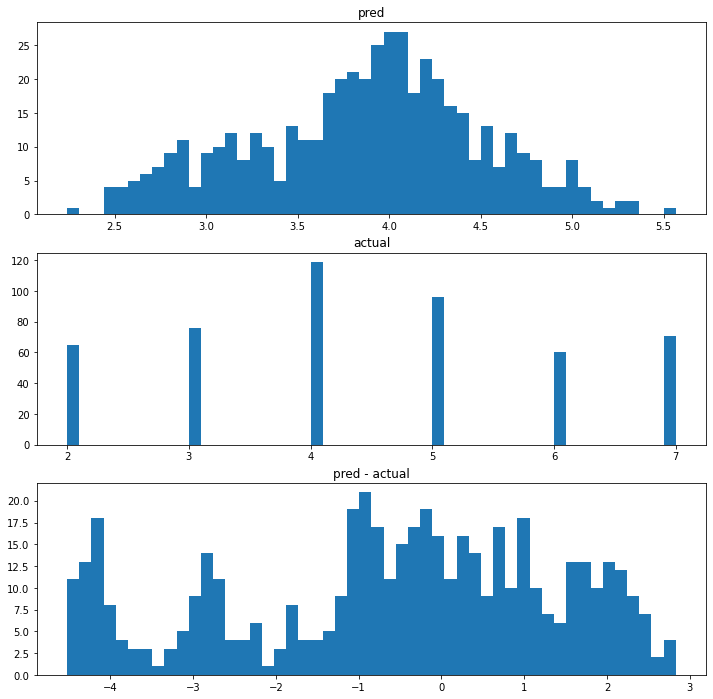

RMSE: 2.054104


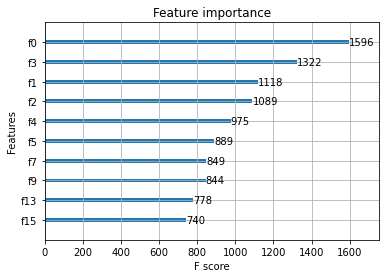

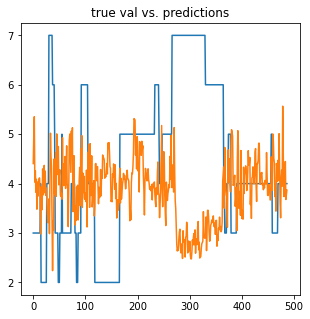

In [31]:
train = pd.concat([df1, df2, df3])
model_emotion = XGBRegressorForSurveyFast(train, test, "stressed")

In [32]:
## add train and test with predicted emotions
train_new = df_with_emotion(train, model_emotion, "stressed")
test_new = df_with_emotion(test, model_emotion, "stressed")
train_new.head()

,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,craving_onset,acc_x_1min__std,acc_x_1min__mxdiff,...,heartrate_1h__mean,heartrate_1h__std,heartrate_1h__agg_linear_trend,conductance_1h__mean,conductance_1h__std,temperature_1h__mean,temperature_1h__std,bvp_1h__mean,bvp_1h__std,pred_stressed
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-28 22:25:25.750000,-50.0,8.0,36.0,-207.130000,0.071755,84.83,30.05,False,9.045650,48.0,...,86.483400,10.615371,4.937402e-12,0.100754,0.052153,31.279694,0.702278,-0.102442,178.906788,6.999293
2020-01-28 23:14:29.406250,-50.0,42.0,6.0,265.620000,0.047409,68.77,33.83,False,10.293232,65.0,...,91.522980,12.133501,-6.662814e-12,0.101910,0.052969,32.570649,1.359237,-1.107961,206.501620,7.000196
2020-01-29 01:03:03.781250,39.0,47.0,1.0,-153.636667,0.155041,78.07,33.39,False,24.924040,47.0,...,90.824730,14.251468,-2.334040e-12,0.358310,0.460069,33.288559,0.690618,-2.269165,195.884236,6.998092
2020-01-29 05:59:54.531250,-48.0,32.0,-29.0,-112.740000,0.116868,83.95,34.43,False,0.000000,0.0,...,94.986895,4.556388,-1.760228e-12,1.013082,0.721093,34.406629,0.128263,0.515853,116.332746,6.999450
2020-01-29 09:37:22.343750,-47.0,35.0,27.0,-131.860000,0.575585,78.13,33.47,False,0.746537,5.0,...,78.919814,1.842960,7.087864e-13,0.517082,0.428290,33.349925,0.167246,-1.367300,77.655617,5.998179


## prediction on craving_onset

In [55]:
model = classify(train_new, test_new)

/Users/yangtian/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6771293093164739 0.5913757700205339
[[221  16]
 [183  67]]


In [56]:
## Print feature importance
importance = model.feature_importances_
names = train_new.columns
found_index = np.in1d(names, 'craving_onset').nonzero()[0]
names = np.delete(names, found_index)
dataset = pd.DataFrame({'importance': importance, 'names': list(names)}, columns=['importance', 'names'])
dataset.sort_values(by=['importance'], inplace=True, ascending=False)
dataset.head(10)

,importance,names
37,0.066944,pred_stressed
24,0.049408,acc_y_1h__std
31,0.044875,conductance_1h__mean
23,0.043287,acc_x_1h__mxdiff
34,0.043117,temperature_1h__std
17,0.042339,conductance_1min__std
1,0.040754,acc_y
27,0.040269,acc_z_1h__mxdiff
29,0.039527,heartrate_1h__std
32,0.037075,conductance_1h__std
